In [1]:
%matplotlib notebook 
# Import modules
import math
import numpy as np
import matplotlib.pyplot
import tables as tb
import itertools
import re
import os

markers=itertools.cycle(('o','v','s','^','<','>','p','P','*','h','H','+','x','X','D','d','|','_'))

iso_list = ['Xe135', 'Kr83', 'I135','U235', 'U236', 'U238', 'Pu238','Pu239', 'Pu240', 'Pu241', 'Pu242', 'Am241', 'Am242', 'H3', 'He4']
colors = matplotlib.pyplot.rcParams['axes.prop_cycle'].by_key()['color']

def merge(a,b):
    final = np.zeros (len(a)+len(b))
    for i in range(len(a)):
        final[2*i]   = a[i]
        final[2*i+1] = b[i]
    return final

def elem_aaa(iso):
    m = re.match(r"(?P<letters>[a-zA-Z]+)(?P<the_rest>.+)$", iso)
    return [m.group('letters'), m.group('the_rest')]

def read_keff_h5(file):
    db = tb.open_file(file, mode='r')
    sim_param = db.root.simulation_parameters
    init_param = db.root.initial_depcode_siminfo
    # Keff at t=0 depletion step
    k_0 = np.array([x['keff_bds'][0] for x in sim_param.iterrows()])
    k_0_e = np.array([x['keff_bds'][1] for x in sim_param.iterrows()])
    # Keff at t=end depletion step
    k_1 = np.array([x['keff_eds'][0] for x in sim_param.iterrows()])
    k_1_e = np.array([x['keff_eds'][1] for x in sim_param.iterrows()])
    day_eds = np.array([x['cumulative_time_at_eds'] for x in sim_param.iterrows()])
    day_bds = np.zeros_like(day_eds)
    for i in range(1, len(day_eds)):
        day_bds[i] = day_eds[i] - (day_eds[i] - day_eds[i-1])
    db.close()
    return day_bds, day_eds, k_0, k_1, k_0_e, k_1_e

def read_iso_m_h5(db_file, iso_list):
    db = tb.open_file(db_file, mode='r')
    fuel_bef_mat = db.root.materials.fuel.before_reproc.parameters
    fuel_bef = db.root.materials.fuel.before_reproc.comp
    isomap = fuel_bef.attrs.iso_map

    fuel_after_mat = db.root.materials.fuel.after_reproc.parameters
    fuel_after = db.root.materials.fuel.after_reproc.comp

    mass_b = np.array([x['mass'] for x in fuel_bef_mat.iterrows()])
    vol_b = np.array([x['volume'] for x in fuel_bef_mat.iterrows()])
    dens_b = np.array([x['density'] for x in fuel_bef_mat.iterrows()])

    mass_a = np.array([x['mass'] for x in fuel_after_mat.iterrows()])
    vol_a = np.array([x['volume'] for x in fuel_after_mat.iterrows()])
    dens_a = np.array([x['density'] for x in fuel_after_mat.iterrows()])

    mass_b = {}
    mass_a = {}
    for iso in iso_list:
        mass_b[iso] = 1e-6*np.array([row[isomap[iso]] for row in fuel_bef])
        mass_a[iso] = 1e-6*np.array([row1[isomap[iso]] for row1 in fuel_after])
    db.close()
    return mass_b, mass_a  # mass in tonnes

In [2]:
# Epsilon=91%, K_L=100ft/hr
db_file = os.path.join(os.getcwd(), '../../db/base_case/base_case_void_011867_3d_9600d.h5')
t_bds, t_eds, k_bds, k_eds, k_bds_err, k_eds_err = read_keff_h5(db_file)
mass_before, mass_after = read_iso_m_h5(db_file, iso_list)
t_comp = np.append(t_bds, t_eds[-1])

# Epsilon=3%, K_L=1ft/hr
db_file_void_5 = os.path.join(os.getcwd(), '../../db/long_term_eps_var/eps_3_kl_1.h5')
t_bds_5, t_eds_5, k_bds_5, k_eds_5, k_bds_err_5, k_eds_err_5 = read_keff_h5(db_file_void_5)
mass_before_5, mass_after_5 = read_iso_m_h5(db_file_void_5, iso_list)
t_comp_5 = np.append(t_bds_5, t_eds_5[-1])

# Epsilon=53%, K_L=25ft/hr
db_file_50 = os.path.join(os.getcwd(), '../../db/long_term_eps_var/eps_50_kl_25.h5')
t_bds_50, t_eds_50, k_bds_50, k_eds_50, k_bds_err_50, k_eds_err_50 = read_keff_h5(db_file_50)
mass_before_50, mass_after_50 = read_iso_m_h5(db_file_50, iso_list)
t_comp_50 = np.append(t_bds_50, t_eds_50[-1])

<IPython.core.display.Javascript object>


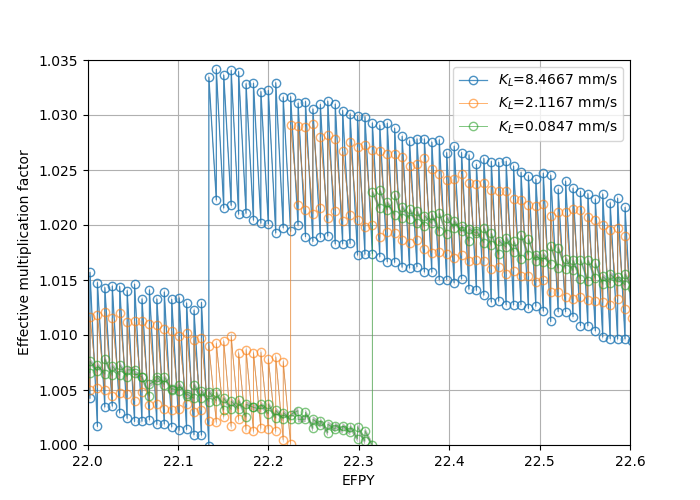

6400 5928 5880


In [41]:
#print(len(k_bds), len(k_bds_7_5[:641]))
keff = merge(k_bds, k_eds)
t = merge(t_bds, t_eds)
err = merge(k_bds_err, k_eds_err)

keff_5 = merge(k_bds_5, k_eds_5)
t_5 = merge(t_bds_5, t_eds_5)
err_5 = merge(k_bds_err_5, k_eds_err_5)

keff_50 = merge(k_bds_50, k_eds_50)
t_50 = merge(t_bds_50, t_eds_50)
err_50 = merge(k_bds_err_50, k_eds_err_50)

# Initialize figure
fig_keff = matplotlib.pyplot.figure(1, figsize=[7,5])
ax = fig_keff.add_subplot(111)
ax.grid(True)
ax.plot(t/365.0, keff,      'o-', label=r'$K_L$=8.4667 mm/s', linewidth=0.9, alpha=0.8, markerfacecolor="None")
ax.plot(t_50/365.0, keff_50,'o-', label=r'$K_L$=2.1167 mm/s', linewidth=0.7, alpha=0.6, markerfacecolor="None")
ax.plot(t_5/365.0, keff_5,  'o-', label=r'$K_L$=0.0847 mm/s', linewidth=0.7, alpha=0.6, markerfacecolor="None")

ax.fill_between(t/365.0, keff-err, keff+err, edgecolor='#808080', facecolor='#BEBEBE', linewidth=0.1)
ax.fill_between(t_5/365.0, keff_5-err_5, keff_5+err_5, edgecolor='#808080', facecolor='#BEBEBE', linewidth=0.1)
ax.fill_between(t_50/365.0, keff_50-err_50, keff_50+err_50, edgecolor='#808080', facecolor='#BEBEBE', linewidth=0.1)

#ax.axhline(y=1.04226, linewidth=1.1, color='r', label='control rods worth')
#ax.legend(loc=0)
ax.set_ylabel('Effective multiplication factor')
#ax.set_xlabel('EFPH')
ax.set_xlabel('EFPY')
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')
#ax.set_xlim(0,max(days2))
#ax.set_ylim([0.75, 1.018])

ax.set_xlim(0, 23.5)
ax.set_ylim(.9985, 1.042)

# Zoomed 1
#ax.set_xlim(0.0, 0.2)
#ax.set_ylim(.999, 1.037)

# Zoomed 2
#ax.set_xlim(11.2, 11.3)
#ax.set_ylim(1.015, 1.0278)

# Zoomed 3
#ax.set_xlim(22.519, 22.67)
#ax.set_ylim(1.005, 1.025)

# Zoomed 4
ax.set_xlim(22.0, 22.6)
ax.set_ylim(1, 1.035)

ax.legend(loc=0)
fig_keff.show()
#fig_keff.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch4/eps/keff_zoomed.png',bbox_inches='tight', dpi=900)
#print(keff[-700:-620])
#print(days_e, len(days_e))
print(len(keff), len(keff_5), len(keff_50))

In [ ]:
indx = []
for i in range(len(keff)):
    if keff[i]-keff[i-1] > 0.03:
        indx.append(t[i])
        print(i, keff[i], t[i], (keff[i]-keff[i-1])*1e5)
print(indx)
print("Months between moderator rods re-configurations ", (np.diff(indx)/30))
print("Average months between moderator rods re-configurations ", (np.mean(np.diff(indx)/30)))

In [ ]:
indx = []
for i in range(len(keff_5)):
    if keff_5[i]-keff_5[i-1] > 0.03:
        indx.append(t_5[i])
        print(i, keff_5[i], t_5[i], (keff_5[i]-keff_5[i-1])*1e5)
print(indx)
print("Months between moderator rods re-configurations ", (np.diff(indx)/30))
print("Average months between moderator rods re-configurations ", (np.mean(np.diff(indx)/30)))

3001 2965


<IPython.core.display.Javascript object>


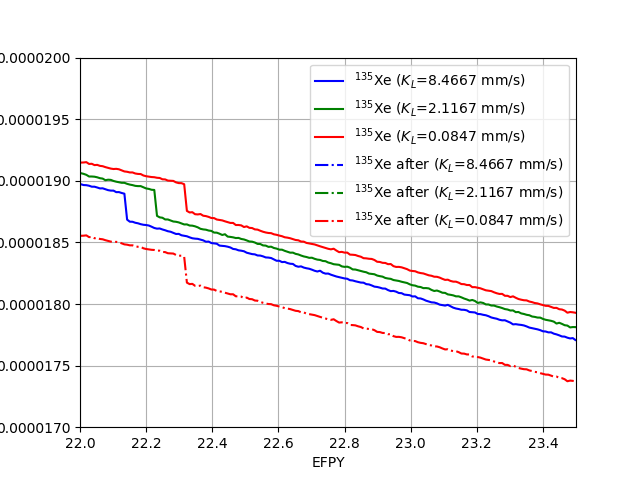

In [13]:
#plot_iso = ['He4']
#plot_iso = ['U235','U238']
plot_iso = ['Xe135']
print(len(t_comp[:3001]), len(t_comp_5))


# Initialize figure
fig_comp = matplotlib.pyplot.figure(3)#, figsize=[7,5])
ax1 = fig_comp.subplots()
ax1.grid(True)

for i in plot_iso:
    m=next(markers)
    el_aaa = elem_aaa(i)
    k_name = "$^{"+str(el_aaa[-1])+"}$"+str(el_aaa[0])
    ax1.plot(t_comp/365.0, mass_before[i], '-', label=str(k_name)+' ($K_L$=8.4667 mm/s)', color='b', linewidth=1.5)
    ax1.plot(t_comp_50/365.0, mass_before_50[i], '-', label=str(k_name)+' ($K_L$=2.1167 mm/s)', color='g', linewidth=1.5)
    ax1.plot(t_comp_5/365.0, mass_before_5[i], '-', label=str(k_name)+' ($K_L$=0.0847 mm/s)', color='r', linewidth=1.5)
    
    #ax1.plot(t_comp/365.0, (1-0.9148573428740562)*mass_before[i], '--', 
    #             label='Exp '+str(k_name)+'($K_L$=100 ft/hr)', color='b', linewidth=2.5)
    #ax1.plot(t_comp_5/365.0, (1-0.03103426584056919)*mass_before_5[i], '--',
    #             label='Exp '+str(k_name)+' ($K_L$=1 ft/hr)', color='r', linewidth=2.5)
    
for i in plot_iso:
    m=next(markers)
    el_aaa = elem_aaa(i)
    k_name = "$^{"+str(el_aaa[-1])+"}$"+str(el_aaa[0])
    ax1.plot(t_comp[1:]/365.0, mass_after[i], '-.', label=str(k_name)+' after ($K_L$=8.4667 mm/s)', color='b', linewidth=1.5)
    ax1.plot(t_comp_50[1:]/365.0, mass_after_50[i], '-.', label=str(k_name)+' after ($K_L$=2.1167 mm/s)', color='g', linewidth=1.5)
    ax1.plot(t_comp_5[1:]/365.0, mass_after_5[i], '-.', label=str(k_name)+' after ($K_L$=0.0847 mm/s)', color='r', linewidth=1.5)
    

ax1.legend(loc=0)
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_ylabel('Mass of the element in the core [t]')
ax1.set_xlabel('EFPY')
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')
ax1.set_xlim(0, 13)
#ax1.set_ylim(0, 7)
#ax1.set_ylim(2e-, 2.5e-5)

#ax2 = ax1.twinx()
#ax2.set_prop_cycle(color=colors[1:])
#ax2.set_ylabel(r'mass difference between 0.012 and 1% void fraction [%]')
#ax2.set_ylabel(r'relative mass difference [%]', color='red')
#for i in plot_iso:
#    m=next(markers)
#    el_aaa = elem_aaa(i)
#    k_name = "$^{"+str(el_aaa[-1])+"}$"+str(el_aaa[0])
#    ax2.plot(t_comp[:3200]/365.0,
#       100*(mass_before_5[i] - mass_before[i][:3200])/mass_before[i][:3200],
#         '--', color='red') #, label=str(k_name)+" (1% void fraction)")

#ax2.legend(loc=4)
#ax2.set_ylim([-0.90, 0.02])
#ax2.tick_params('y', colors='r')
#ax2.set_ylim([-0.65, 0.02])
#ax2.set_ylim([-1.65, -0.38])

# Zoom 1 (hard spectrum)
ax1.set_xlim(0, 1.5)
ax1.set_ylim(0.000021, 0.0000235)

# Zoom 2 (soft)
ax1.set_xlim(22, 23.5)
ax1.set_ylim(0.000017, 0.00002)

fig_comp.show()
#fig_comp.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch4/eps/xe135.png',bbox_inches='tight', dpi=700)
#fig_comp.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch4/void/pu239.png',bbox_inches='tight', dpi=700)
#fig_comp.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch4/void/u238.png',bbox_inches='tight', dpi=700)

<IPython.core.display.Javascript object>


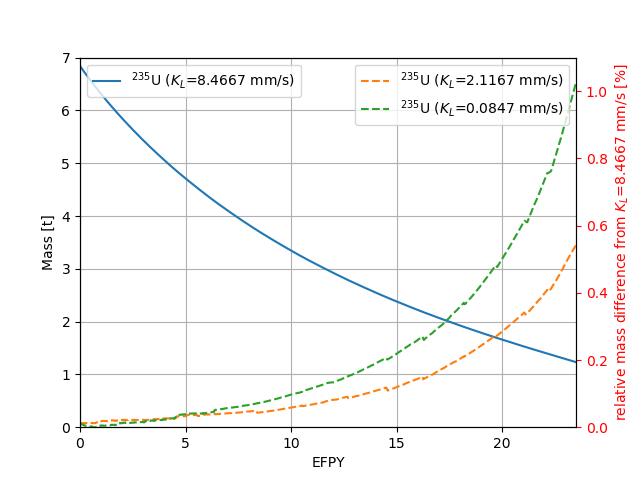

In [15]:
plot_iso = ['U235']
# Initialize figure
fig_comp2 = matplotlib.pyplot.figure(4)#, figsize=[7,5])
ax1 = fig_comp2.subplots()
ax1.grid(True)

for i in plot_iso:
    m=next(markers)
    el_aaa = elem_aaa(i)
    k_name = "$^{"+str(el_aaa[-1])+"}$"+str(el_aaa[0])
    ax1.plot(t_comp/365.0, mass_before[i], '-', label=str(k_name)+' ($K_L$=8.4667 mm/s)', linewidth=1.5)
    #ax1.plot(t_comp_5/365.0, mass_before_5[i], '-', label=str(k_name)+' ($K_L$=1 ft/hr)', color='r', linewidth=1.5)
    #ax1.plot(t_comp_50/365.0, mass_before_50[i], '-', label=str(k_name)+' ($K_L$=25 ft/hr)', color='g', linewidth=1.5)

ax1.legend(loc=2)
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.set_ylabel('Mass [t]')
ax1.set_xlabel('EFPY')
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')
ax1.set_xlim(0, 23.5)
ax1.set_ylim(0, 7)
#ax1.set_ylim(2e-, 2.5e-5)

ax2 = ax1.twinx()
ax2.set_prop_cycle(color=colors[1:])
#ax2.set_ylabel(r'mass difference from $\epsilon_{Xe}=0.915$ [%]')
ax2.set_ylabel(r'relative mass difference from $K_L$=8.4667 mm/s [%]', color='red')
for i in plot_iso:
    m=next(markers)
    el_aaa = elem_aaa(i)
    k_name = "$^{"+str(el_aaa[-1])+"}$"+str(el_aaa[0])
    ax2.plot(t_comp[:2941]/365.0,
       100*(mass_before_50[i] - mass_before[i][:2941])/mass_before[i][:2941],
         '--', label=str(k_name)+" ($K_L$=2.1167 mm/s)")
    ax2.plot(t_comp[:2965]/365.0,
       100*(mass_before_5[i] - mass_before[i][:2965])/mass_before[i][:2965],
         '--', label=str(k_name)+" ($K_L$=0.0847 mm/s)")


ax2.legend(loc=1)
ax2.set_ylim(0, 1.1)
ax2.tick_params('y', colors='r')
#ax2.set_ylim([-0.65, 0.02])
#ax2.set_ylim([-1.65, -0.38])


fig_comp2.show()
#fig_comp2.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch4/eps/u235.png',bbox_inches='tight', dpi=700)